In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm # Progress bar

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-project/__results__.html
/kaggle/input/ml-project/test_df.pkl
/kaggle/input/ml-project/train_df.pkl
/kaggle/input/ml-project/__notebook__.ipynb
/kaggle/input/ml-project/__output__.json
/kaggle/input/ml-project/custom.css
/kaggle/input/ml-project/__results___files/__results___31_0.png
/kaggle/input/ml-project/__results___files/__results___24_0.png
/kaggle/input/ml-project/__results___files/__results___27_0.png
/kaggle/input/ml-project/__results___files/__results___33_0.png
/kaggle/input/ml-project/__results___files/__results___44_0.png
/kaggle/input/ml-project/__results___files/__results___45_1.png


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# For ML models & tools
import sklearn

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Utilities
import os, random, pickle    

In [2]:
root = '../input/ml-project/'

train_df = pd.read_pickle(root + 'train_df.pkl')
test_df = pd.read_pickle(root + 'test_df.pkl')

train_df.head()

,building_id,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month_datetime,hour_datetime,day_week,day_month_datetime
2016-01-01 00:00:00,1277,51.484798,14,4,10,13.296875,0.000000,6.101562,0.0,1016.5,210.0,2.599609,1,0,4,1
2016-01-01 01:00:00,1277,69.312897,14,4,10,5.601562,0.000000,-0.600098,0.0,1019.5,300.0,2.599609,1,1,4,1
2016-01-01 02:00:00,1277,51.151600,14,4,10,5.601562,4.000000,-0.600098,0.0,1019.5,300.0,2.599609,1,2,4,1
2016-01-01 03:00:00,1277,50.318501,14,4,10,5.601562,3.333984,-1.099609,0.0,1019.5,295.0,1.500000,1,3,4,1
2016-01-01 04:00:00,1277,62.481602,14,4,10,5.000000,2.666016,-2.199219,0.0,1019.0,290.0,3.099609,1,4,4,1


# Task #1: Predicting the future temperature

For this task, we'll use the energy consumption as a feature, combined with previous samples of temperature (from the past), as well as building and weather data.

## Constructing a Lag matrix

In [3]:
LAGS = 1
HORIZON = 24

In [4]:
lagged_features =  [ 'air_temperature',     
                     'meter_reading',
#                      'cloud_coverage',       
#                      'dew_temperature',       
#                      'precip_depth_1_hr',  
                     #'sea_level_pressure',   
                     #'wind_direction',        
                     #'wind_speed',  
                     #'month_datetime',
#                      'hour_datetime',
                     #'day_week',
                     #'day_month_datetime'
                   ]
columns_to_drop = [
                     'sea_level_pressure',   
                     'wind_direction', 
                     'wind_speed',
                     'building_id',
                     'primary_use',
                     'square_feet',
                     'day_week',
                     'day_month_datetime'
                  ]

target_feature = 'air_temperature'

In [5]:
# We do not drop the target feature (temperature) because we'll use it for predicting its future values
train_x, train_y = train_df.drop(columns=columns_to_drop), train_df[target_feature]
test_x, test_y = test_df.drop(columns=columns_to_drop), test_df[target_feature]

train_x

,meter_reading,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,month_datetime,hour_datetime
2016-01-01 00:00:00,51.484798,14,13.296875,0.000000,6.101562,0.0,1,0
2016-01-01 01:00:00,69.312897,14,5.601562,0.000000,-0.600098,0.0,1,1
2016-01-01 02:00:00,51.151600,14,5.601562,4.000000,-0.600098,0.0,1,2
2016-01-01 03:00:00,50.318501,14,5.601562,3.333984,-1.099609,0.0,1,3
2016-01-01 04:00:00,62.481602,14,5.000000,2.666016,-2.199219,0.0,1,4
...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,13.000000,14,6.699219,0.000000,-8.296875,0.0,12,19
2016-12-31 20:00:00,12.000000,14,5.601562,4.000000,-6.699219,0.0,12,20
2016-12-31 21:00:00,13.000000,14,5.601562,4.000000,-6.699219,0.0,12,21
2016-12-31 22:00:00,12.000000,14,5.601562,4.000000,-6.699219,0.0,12,22


In [6]:
def build_lag_matrix(df, columns, lags=2, dropna=False):
    """
    Build a lag matrix for specified columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list): List of columns for which the lag matrix is built.
    - lags (int, optional): The number of lag observations to include. Defaults to 2.
    - dropna (bool, optional): Whether to drop rows with NaN values. Defaults to False.

    Returns:
    - pd.DataFrame: A DataFrame containing the original columns and their lagged values.
    """
    # Initialize a dictionary to store column values and lagged values
    result_dict = {}

    # Loop through each specified column
    for col_name in columns:
        # Add the original column to the dictionary
        result_dict[col_name] = df[col_name]

        # Create lagged columns for the current column
        for l in range(1, lags + 1):
            lagged_col_name = f'{col_name}_lag_{l}'
            result_dict[lagged_col_name] = df[col_name].shift(l)
            
    # Include all other columns from the original DataFrame
    for col_name in df.columns:
        if col_name not in columns:
            result_dict[col_name] = df[col_name]

    # Create a DataFrame from the dictionary, using the original DataFrame's index
    result = pd.DataFrame(result_dict, index=df.index)
    
    if dropna:
        return result.dropna()

    return result

In [7]:
train_x = build_lag_matrix(train_x, lagged_features, lags=LAGS, dropna=False)
test_x = build_lag_matrix(test_x, lagged_features, lags=LAGS, dropna=False)

train_x.head()

,air_temperature,air_temperature_lag_1,meter_reading,meter_reading_lag_1,site_id,cloud_coverage,dew_temperature,precip_depth_1_hr,month_datetime,hour_datetime
2016-01-01 00:00:00,13.296875,NaN,51.484798,NaN,14,0.000000,6.101562,0.0,1,0
2016-01-01 01:00:00,5.601562,13.296875,69.312897,51.484798,14,0.000000,-0.600098,0.0,1,1
2016-01-01 02:00:00,5.601562,5.601562,51.151600,69.312897,14,4.000000,-0.600098,0.0,1,2
2016-01-01 03:00:00,5.601562,5.601562,50.318501,51.151600,14,3.333984,-1.099609,0.0,1,3
2016-01-01 04:00:00,5.000000,5.601562,62.481602,50.318501,14,2.666016,-2.199219,0.0,1,4


One issue is that Pandas shift() function causes some columns to change their dtype.
So, we convert than back to the original dtype.

In [8]:
from pandas.core.dtypes.common import is_dtype_equal

# Discard the NaNs which appeared after adding lagged columns
train_x, test_x = train_x.dropna(), test_x.dropna()

# Convert columns with time-related info back to int8
features_dict = train_x.dtypes

for feature in features_dict.keys():
    if is_dtype_equal(features_dict[feature], np.float64):
        train_x[feature] = train_x[feature].astype(np.int8)
        test_x[feature] = test_x[feature].astype(np.int8)

print('Training column types: ', train_x.dtypes)

Training column types:  air_temperature          float32
air_temperature_lag_1    float32
meter_reading            float32
meter_reading_lag_1      float32
site_id                     int8
cloud_coverage           float16
dew_temperature          float32
precip_depth_1_hr        float16
month_datetime              int8
hour_datetime               int8
dtype: object


## Adding weather forecast for prediction

Since we have available weather (forecast) data to predict the future temperature values, we'll use it here

In [9]:
def add_weather_forecast(df, columns, horizon=1, dropna=False):
    """Adds new weather columns with future observations to a dataset df (in place).
       The future observations are taken 'horizon' hours from the current prediction hour.
       """
    result = df.copy()
    
    for col_name in columns:
        for n in range(1, horizon + 1):
            # Create future lagged columns for the current column        
            result[f'{col_name}_future_lag_{n}'] = df[col_name].shift(-n)
        
    if dropna:
        return result.dropna()
    
    return result

We'll use only the most important columns fo the forecast

In [10]:
forecast_columns = [#'cloud_coverage',       
                    'dew_temperature',       
                    #'precip_depth_1_hr'
                   ]

## Input & Target arrays construction

First, **we'll discard the first *LAGS* values, as they have been discarded in the feature matrix.**

In [11]:
train_y = train_y.iloc[LAGS:]
test_y = test_y.iloc[LAGS:]

assert len(train_y) == len(train_x)
assert len(test_y) == len(test_x)

Now we'll construct the datasets for each value of N = 1, 2, ..., HORIZON, where N is the number of hours to predict in the future.\
For each such dataset:

**X_N** will contain the lagged temperature, electricity consumption, weather data, **as well as weather forecast data up to N hours in the future**.

**Y_N** will contain the shifted (by N) future temperature values which we'll need to predict.

In [12]:
# Constructs the X_N matrices from the above definition for training and testing
def construct_x_n(n):
    # Add the weather forecast
    train_x_n = add_weather_forecast(train_x, forecast_columns, n, dropna=True)
    test_x_n = add_weather_forecast(test_x, forecast_columns, n, dropna=True)
    
    return train_x_n, test_x_n
    
# Constructs the Y_N matrices from the above definition for training and testing
def construct_y_n(n):
    # Shift the target array by N
    train_y_n = train_y.shift(-n).dropna()
    test_y_n = test_y.shift(-n).dropna()
    
    return train_y_n, test_y_n

# Feature Importances

In order to understand better which features cotribute the most to the predictive abilities of decisions tree based models, we compute the feature importances by fitting random forest models on the training dataset.

In [19]:
PLOT_IMPORTANCES = True
SEED = 42 # For consistent results

def plot_feature_importances(forest, horizon, feature_names = None):
    if feature_names is None:
        feature_names = train_x.columns
        
    fig, ax = plt.subplots()

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
        
    forest_importances = pd.Series(importances, index=feature_names)
    # Additionally, plot standard deviatons of importances across the different trees
    forest_importances.plot.bar(yerr=std, ax=ax)
    
    ax.set_title(f"Feature importance: N = {horizon}")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

100%|██████████| 3/3 [00:39<00:00, 13.27s/it]


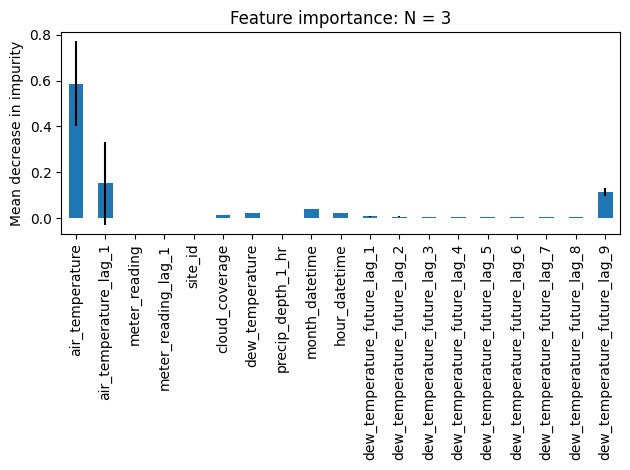

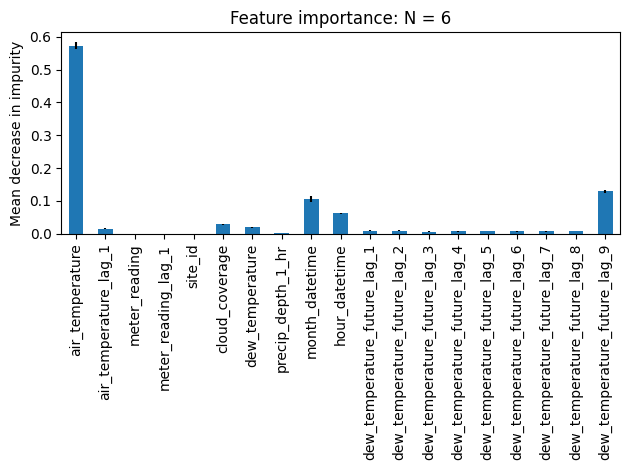

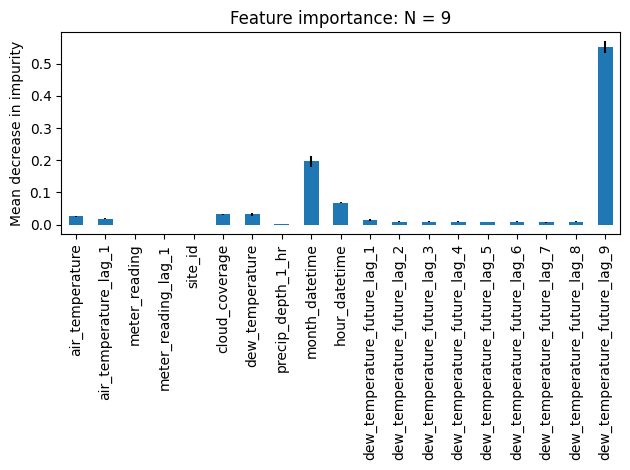

In [20]:
if PLOT_IMPORTANCES:
    from sklearn.ensemble import RandomForestRegressor
    n_to_plot = [3, 6, 9]
    
    for n in tqdm(n_to_plot):
        train_x, test_x = construct_x_n(n)
        train_y, test_y = construct_y_n(n)
    
        # Fit the RF model on the training dataset
        forest = RandomForestRegressor(random_state=SEED, n_estimators=20, n_jobs=-1)
        forest.fit(train_x, train_y)

        # Resulting plot
        plot_feature_importances(forest, n, feature_names=train_x.columns)

In [21]:
from sklearn.metrics import mean_squared_error

def root_mean_squared_error(true_y, pred_y):
    return mean_squared_error(true_y, pred_y, squared=False)

def normalized_root_mean_squared_error(true_y, pred_y):
    rmse = root_mean_squared_error(true_y, pred_y)
    max_y = max(max(true_y), max(pred_y))
    min_y = min(min(true_y), min(pred_y))
    return rmse / (max_y - min_y)

In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV
from sklearn.linear_model import PassiveAggressiveRegressor, SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

LINEAR_REGRESSOR = 'Linear Regression'
RIDGE = 'Ridge'
LASSO = 'Lasso'
ELASTIC_NET_CV = 'Elastic Net CV'
PASSIVE_AGGRESSIVE_REGRESSOR = 'Passive Aggressive Regression'
SGD_REGRESSOR_HUBER = 'SGD Regression Huber'
KERNEL_RIDGE = 'Kernel Ridge'
SV_REGRESSOR = 'SVR'
DECISION_TREE_REGRESSOR = 'Decision Tree Regression'
RANDOM_FOREST_REGRESSOR = 'Random Forest Regression'

models = {
    LINEAR_REGRESSOR: LinearRegression(),
    RIDGE: Ridge(),
    LASSO: Lasso(),
    ELASTIC_NET_CV: ElasticNetCV(n_jobs=-1),
    PASSIVE_AGGRESSIVE_REGRESSOR: PassiveAggressiveRegressor(),
    SGD_REGRESSOR_HUBER: SGDRegressor(loss='huber'),
    DECISION_TREE_REGRESSOR: DecisionTreeRegressor(random_state=SEED, min_samples_split=10, max_depth=40),
#     RANDOM_FOREST_REGRESSION: RandomForestRegressor(random_state=SEED, n_estimators=20, n_jobs=-1,
#                                                     min_samples_split=10, max_depth=40),
    
#     SV_REGRESSOR: SVR(),
#     KERNEL_RIDGE: KernelRidge(),
}

rmses = {label: list() for label in models.keys()}
nrmses = {label: list() for label in models.keys()}

n_to_plot = range(1, HORIZON + 1)

for name, model in models.items():
    print(f'Fitting {name} model...')
    for n in tqdm(n_to_plot):
        train_x, test_x = construct_x_n(n)
        train_y, test_y = construct_y_n(n)

        model.fit(train_x, train_y)
        pred_y = model.predict(test_x)

        rmse = root_mean_squared_error(test_y, pred_y)
        nrmse = normalized_root_mean_squared_error(test_y, pred_y)

        rmses[name].append(rmse)
        nrmses[name].append(nrmse)

Fitting Linear Regression model...


100%|██████████| 24/24 [00:10<00:00,  2.29it/s]


Fitting Ridge model...


  0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.25692e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
  4%|▍         | 1/24 [00:00<00:06,  3.30it/s]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.25693e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
  8%|▊         | 2/24 [00:00<00:07,  3.09it/s]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.25694e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
 12%|█▎        | 3/24 [00:00<00:06,  3.05it/s]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.25695e-11): resul

Fitting Lasso model...


100%|██████████| 24/24 [02:08<00:00,  5.34s/it]


Fitting Elastic Net CV model...


100%|██████████| 24/24 [04:11<00:00, 10.47s/it]


Fitting Passive Aggressive Regression model...


100%|██████████| 24/24 [00:35<00:00,  1.48s/it]


Fitting SGD Regression Huber model...


100%|██████████| 24/24 [03:15<00:00,  8.16s/it]


Fitting Decision Tree Regression model...


100%|██████████| 24/24 [01:43<00:00,  4.31s/it]


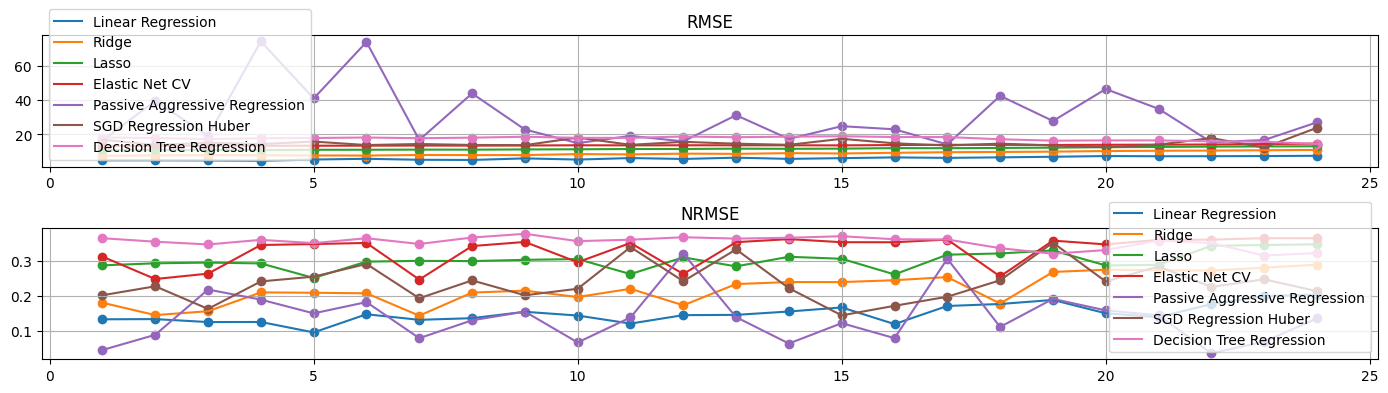

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 4))

ax1.grid(True)
for label, rmse in rmses.items():
    ax1.plot(n_to_plot, rmse, label=label)
    ax1.scatter(n_to_plot, rmse)
    ax1.set_title('RMSE')
ax1.legend()

ax2.grid(True)
for label, nrmse in nrmses.items():
    ax2.plot(n_to_plot, nrmse, label=label)
    ax2.scatter(n_to_plot, nrmse)
ax2.set_title('NRMSE')
ax2.legend()

fig.tight_layout()

In [24]:
for name in rmses.keys():
    model_rmse = np.array(rmses[name])
    model_nrmse = np.array(nrmses[name])

    np.save(f'{name}_rmse', model_rmse)
    np.save(f'{name}_nrmse', model_nrmse)

# Task 2: Predicting electricity consumption

In [52]:
LAGS = 3
SEED = 42

In [53]:
lagged_features = [ 'air_temperature',     
#                     'meter_reading',
                     # 'cloud_coverage',       
                     # 'dew_temperature',       
                     'precip_depth_1_hr',  
                     #'sea_level_pressure',   
                     #'wind_direction',        
                     #'wind_speed',  
                     #'month_datetime',
                     # 'hour_datetime',
                     #'day_week',
                     #'day_month_datetime'
                  ]
columns_to_drop = [
                     'meter_reading',
                     'sea_level_pressure',   
                     'wind_direction', 
                     'wind_speed'
                  ]

target_feature = 'meter_reading'

## Constructing a Lag matrix

In [54]:
def build_lag_matrix(df, columns, lags=2, dropna=False):
    """
    Build a lag matrix for specified columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list): List of columns for which the lag matrix is built.
    - lags (int, optional): The number of lag observations to include. Defaults to 2.
    - dropna (bool, optional): Whether to drop rows with NaN values. Defaults to False.

    Returns:
    - pd.DataFrame: A DataFrame containing the original columns and their lagged values.
    """
    # Initialize a dictionary to store column values and lagged values
    result_dict = {}

    # Loop through each specified column
    for col_name in columns:
        # Add the original column to the dictionary
        result_dict[col_name] = df[col_name]

        # Create lagged columns for the current column
        for l in range(1, lags + 1):
            lagged_col_name = f'{col_name}_lag_{l}'
            result_dict[lagged_col_name] = df[col_name].shift(l)
            
    # Include all other columns from the original DataFrame
    for col_name in df.columns:
        if col_name not in columns:
            result_dict[col_name] = df[col_name]

    # Create a DataFrame from the dictionary, using the original DataFrame's index
    result = pd.DataFrame(result_dict, index=df.index)
    
    if dropna:
        return result.dropna()

    return result

from sklearn.metrics import mean_squared_error

def root_mean_squared_error(true_y, pred_y):
    return mean_squared_error(true_y, pred_y, squared=True)

def normalized_root_mean_squared_error(true_y, pred_y):
    rmse = root_mean_squared_error(true_y, pred_y)
    max_y = max(max(true_y), max(pred_y))
    min_y = min(min(true_y), min(pred_y))
    return rmse / (max_y - min_y)

In [55]:
# We do not drop the target feature (temperature) because we'll use it for predicting its future values
train_x, train_y = train_df.drop(columns=columns_to_drop), train_df[target_feature]
test_x, test_y = test_df.drop(columns=columns_to_drop), test_df[target_feature]

train_x

,building_id,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,month_datetime,hour_datetime,day_week,day_month_datetime
2016-01-01 00:00:00,1277,14,4,10,13.296875,0.000000,6.101562,0.0,1,0,4,1
2016-01-01 01:00:00,1277,14,4,10,5.601562,0.000000,-0.600098,0.0,1,1,4,1
2016-01-01 02:00:00,1277,14,4,10,5.601562,4.000000,-0.600098,0.0,1,2,4,1
2016-01-01 03:00:00,1277,14,4,10,5.601562,3.333984,-1.099609,0.0,1,3,4,1
2016-01-01 04:00:00,1277,14,4,10,5.000000,2.666016,-2.199219,0.0,1,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1324,14,1,11,6.699219,0.000000,-8.296875,0.0,12,19,5,31
2016-12-31 20:00:00,1324,14,1,11,5.601562,4.000000,-6.699219,0.0,12,20,5,31
2016-12-31 21:00:00,1324,14,1,11,5.601562,4.000000,-6.699219,0.0,12,21,5,31
2016-12-31 22:00:00,1324,14,1,11,5.601562,4.000000,-6.699219,0.0,12,22,5,31


In [56]:
train_x = build_lag_matrix(train_x, lagged_features, lags=LAGS, dropna=False)
test_x = build_lag_matrix(test_x, lagged_features, lags=LAGS, dropna=False)

if 'meter_reading' in lagged_features:
    del train_x['meter_reading'], test_x['meter_reading']
else:
    assert 'meter_reading' in columns_to_drop

train_x.head()

,air_temperature,air_temperature_lag_1,air_temperature_lag_2,air_temperature_lag_3,precip_depth_1_hr,precip_depth_1_hr_lag_1,precip_depth_1_hr_lag_2,precip_depth_1_hr_lag_3,building_id,site_id,primary_use,square_feet,cloud_coverage,dew_temperature,month_datetime,hour_datetime,day_week,day_month_datetime
2016-01-01 00:00:00,13.296875,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1277,14,4,10,0.000000,6.101562,1,0,4,1
2016-01-01 01:00:00,5.601562,13.296875,NaN,NaN,0.0,0.0,NaN,NaN,1277,14,4,10,0.000000,-0.600098,1,1,4,1
2016-01-01 02:00:00,5.601562,5.601562,13.296875,NaN,0.0,0.0,0.0,NaN,1277,14,4,10,4.000000,-0.600098,1,2,4,1
2016-01-01 03:00:00,5.601562,5.601562,5.601562,13.296875,0.0,0.0,0.0,0.0,1277,14,4,10,3.333984,-1.099609,1,3,4,1
2016-01-01 04:00:00,5.000000,5.601562,5.601562,5.601562,0.0,0.0,0.0,0.0,1277,14,4,10,2.666016,-2.199219,1,4,4,1


In [57]:
from pandas.core.dtypes.common import is_dtype_equal

# Discard the NaNs which appeared after adding lagged columns
train_x, test_x = train_x.dropna(), test_x.dropna()

# Convert columns with time-related info back to int8
features_dict = train_x.dtypes

for feature in features_dict.keys():
    if is_dtype_equal(features_dict[feature], np.float64):
        train_x[feature] = train_x[feature].astype(np.int8)
        test_x[feature] = test_x[feature].astype(np.int8)

print('Training column types: ', train_x.dtypes)

Training column types:  air_temperature            float32
air_temperature_lag_1      float32
air_temperature_lag_2      float32
air_temperature_lag_3      float32
precip_depth_1_hr          float16
precip_depth_1_hr_lag_1    float16
precip_depth_1_hr_lag_2    float16
precip_depth_1_hr_lag_3    float16
building_id                  int16
site_id                       int8
primary_use                   int8
square_feet                  int32
cloud_coverage             float16
dew_temperature            float32
month_datetime                int8
hour_datetime                 int8
day_week                      int8
day_month_datetime            int8
dtype: object


## Input & Target arrays construction

**We'll discard the first *LAGS* values, as they have been discarded in the feature matrix.**

In [58]:
train_y = train_y.iloc[LAGS:]
test_y = test_y.iloc[LAGS:]

assert len(train_y) == len(train_x)
assert len(test_y) == len(test_x)

len(train_y)

276189

That's all here: we're going to predict the electricity consumption at the current hour of prediction, so we don't need to do any further preprocessing of the dataset.

# Feature Importances

In [59]:
PLOT_IMPORTANCES = True
SEED = 42 # For consistent results

def plot_feature_importances(forest, feature_names = None):
    if feature_names is None:
        feature_names = train_x.columns
        
    fig, ax = plt.subplots()

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
        
    forest_importances = pd.Series(importances, index=feature_names)
    # Additionally, plot standard deviatons of importances across the different trees
    forest_importances.plot.bar(yerr=std, ax=ax)
    
    ax.set_title(f"Feature importances")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

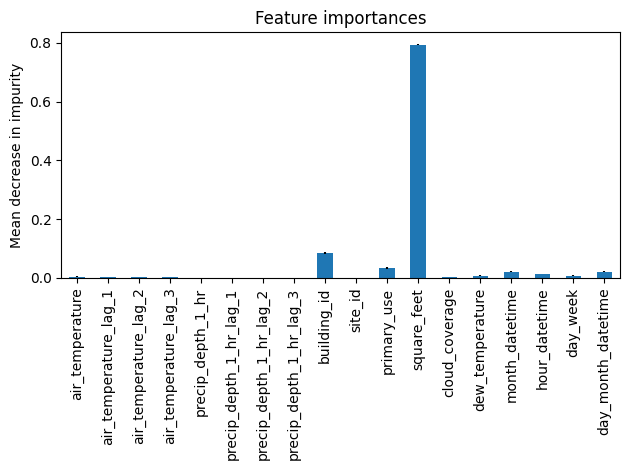

In [60]:
if PLOT_IMPORTANCES:
    from sklearn.ensemble import RandomForestRegressor
        
    # Fit the RF model on the training dataset
    forest = RandomForestRegressor(random_state=SEED, n_estimators=20, n_jobs=-1)
    forest.fit(train_x, train_y)

    # Resulting plot
    plot_feature_importances(forest, feature_names=train_x.columns)

In [61]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV
from sklearn.linear_model import PassiveAggressiveRegressor, SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

LINEAR_REGRESSOR = 'Linear Regression'
RIDGE = 'Ridge'
LASSO = 'Lasso'
ELASTIC_NET_CV = 'Elastic Net CV'
PASSIVE_AGGRESSIVE_REGRESSOR = 'Passive Agressive Regression'
SGD_REGRESSOR_HUBER = 'SGD Regression Huber'
KERNEL_RIDGE = 'Kernel Ridge'
SV_REGRESSOR = 'SVR'
DECISION_TREE_REGRESSOR = 'Decision Tree Regression'
RANDOM_FOREST_REGRESSOR = 'Random Forest Regression'

models = {
    LINEAR_REGRESSOR: LinearRegression(),
    RIDGE: Ridge(),
    LASSO: Lasso(),
    ELASTIC_NET_CV: ElasticNetCV(n_jobs=-1),
    PASSIVE_AGGRESSIVE_REGRESSOR: PassiveAggressiveRegressor(),
    SGD_REGRESSOR_HUBER: SGDRegressor(loss='huber'),
    DECISION_TREE_REGRESSOR: DecisionTreeRegressor(random_state=SEED, min_samples_split=10, max_depth=40),
    RANDOM_FOREST_REGRESSOR: RandomForestRegressor(random_state=SEED, n_estimators=20, n_jobs=-1,
                                                    min_samples_split=10, max_depth=40),
    
#     SV_REGRESSOR: SVR(),
#     KERNEL_RIDGE: KernelRidge(),
}


Fitting Linear Regression...
RMSE: 44160.82785786681
NRMSE: 20.926099928800298

Fitting Ridge...
RMSE: 44160.83267994384
NRMSE: 20.926114820306324

Fitting Lasso...
RMSE: 44169.15972251583
NRMSE: 20.992954548471623

Fitting Elastic Net CV...
RMSE: 49265.70449545203
NRMSE: 24.912403370096186

Fitting Passive Agressive Regression...
RMSE: 48621.48830334037
NRMSE: 22.632014716811945

Fitting SGD Regression Huber...
RMSE: 75481.46637497644
NRMSE: 36.717080841208336

Fitting Decision Tree Regression...
RMSE: 12162.676781168584
NRMSE: 6.21325265996764

Fitting Random Forest Regression...
RMSE: 8286.803758043443
NRMSE: 4.234485707952172


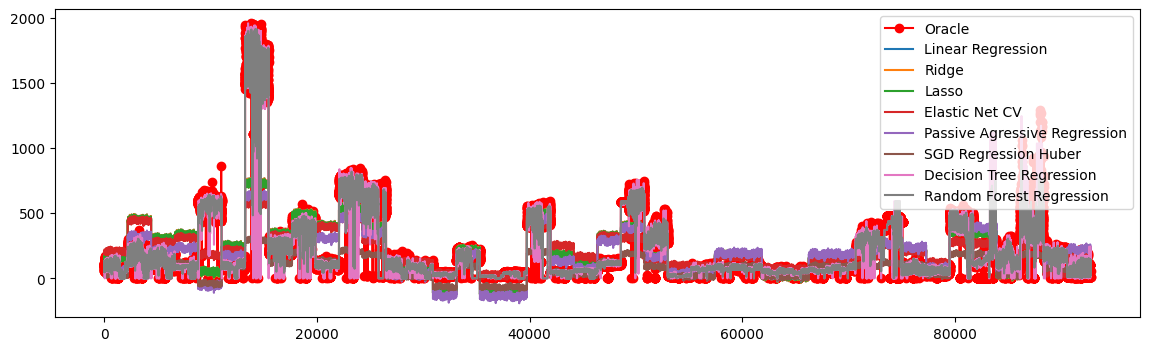

In [62]:
predictions = dict()

for model_name, model in models.items():
    print(f'\nFitting {model_name}...')

    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    predictions[model_name] = pred_y
    
    rmse = root_mean_squared_error(test_y, pred_y)
    nrmse = normalized_root_mean_squared_error(test_y, pred_y)
    
    print('RMSE:', rmse)
    print('NRMSE:', nrmse)
    
x = range(len(test_y))
plt.figure(figsize=(14, 4))
plt.plot(x, test_y, marker='o', color='red', label='Oracle')
for model_name, preds in predictions.items():
    plt.plot(x, preds, label=model_name)
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import r2_score

for key in predictions.keys():
    y_pred = predictions[key]
    
    print(f'{key}:\n\tR^2 = {r2_score(test_y, y_pred):.3f}')

Linear Regression:
	R^2 = 0.447
Ridge:
	R^2 = 0.447
Lasso:
	R^2 = 0.447
Elastic Net CV:
	R^2 = 0.383
Passive Agressive Regression:
	R^2 = 0.391
SGD Regression Huber:
	R^2 = 0.055
Decision Tree Regression:
	R^2 = 0.848
Random Forest Regression:
	R^2 = 0.896
